In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Analyzing Python dependencies with BigQuery DataFrames

In this notebook, you'll use the [PyPI public dataset](https://console.cloud.google.com/marketplace/product/gcp-public-data-pypi/pypi) and the [deps.dev public dataset](https://deps.dev/) to visualize Python package downloads for a package and its dependencies.

> **⚠ Important**
>
> You'll use features that are currently in [preview](https://cloud.google.com/blog/products/gcp/google-cloud-gets-simplified-product-launch-stages): `ordering_mode="partial"` and "NULL" indexes. There may be breaking changes to this functionality in future versions of the BigQuery DataFrames package.



In [5]:
import bigframes.pandas as bpd

# Preview feature warning:
# Use `ordering_mode="partial"` for more efficient query generation, but
# some pandas-compatible methods may not be possible without a total ordering.
bpd.options.bigquery.ordering_mode = "partial"

Filter out the relevant warnings for preview features used.

In [6]:
import warnings

import bigframes.exceptions

warnings.simplefilter("ignore", category=bigframes.exceptions.NullIndexPreviewWarning)
warnings.simplefilter("ignore", category=bigframes.exceptions.OrderingModePartialPreviewWarning)

## Counting downloads and tracking dependencies

The [PyPI `file_downloads`](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2spypi!3sfile_downloads) table contains a row for each time there is a download request for a package. The [deps.dev Dependencies](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2sdeps_dev_v1!3sDependencies) table contains a row for each dependency of each package.

When `ordering_mode = "partial"`, `read_gbq_table` creates a DataFrame representing the table, but the DataFrame has no native ordering or index.

In [4]:
import bigframes.enums

# Without ordering_mode = "partial" it is recommended that you set
# the "filters" parameter to limit the number of rows subsequent queries
# have to read.
pypi = bpd.read_gbq_table(
    "bigquery-public-data.pypi.file_downloads",

    # Using ordering_mode = "partial" changes the default index to a "NULL"
    # index, meaning no index is available for implicit joins.
    #
    # Setting this explicitly avoids a DefaultIndexWarning.
    index_col=bigframes.enums.DefaultIndexKind.NULL,
)
deps = bpd.read_gbq_table(
    "bigquery-public-data.deps_dev_v1.Dependencies",
    index_col=bigframes.enums.DefaultIndexKind.NULL,
)

## Limit to the most recent 30 days of data

The PyPI and deps.dev tables are partitioned by date. Query only the most recent 30 days of data to reduce the number of bytes scanned.

Just as with the default ordering mode, filters can be describe in a pandas-compatible way by passing a Boolean Series to the DataFrame's `__getitem__` accessor.

In [7]:
import datetime

last_30_days = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30)
pypi = pypi[pypi["timestamp"] > last_30_days]
deps = deps[(deps["SnapshotAt"] > last_30_days) & (deps["System"] == "PYPI")]


**⚠ Warning**

Without `ordering_mode = "partial"`, these filters do not change the number of bytes scanned. Instead, add column and row filters at "read" time. For example,

```
import datetime

last_30_days = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30)

# Without ordering_mode = "partial", one must limit the data at "read" time to reduce bytes scanned.
pypi = bpd.read_gbq_table(
    "bigquery-public-data.pypi.file_downloads",
    columns=["timestamp", "project"],
    filters=[("timestamp", ">", last_30_days)],
)
```

## Find dependencies for pandas

Use assign to add columns to the DataFrame after a scalar operations, such as extracting a sub-field from a `STRUCT` column.

Because the DataFrame has no index, this does not work if the new column belongs to a different table expression.

In [15]:
deps = deps.assign(DependencyName=deps["Dependency"].struct.field("Name"))

Use an aggregation to identify the unique `DependencyName`s for the `pandas` package. Note: `drop_duplicates()` is not supported, as the order-based behavior such as `keep="first"` is not applicable when using `ordering_mode = "partial"`.

A DataFrame with no index still supports aggregation operations. Set `as_index=False` to keep the GROUP BY keys as regular columns, instead of turning them into an index.

In [ ]:
pandas_deps = deps[deps["Name"] == "pandas"].groupby(["Name", "DependencyName"], as_index=False).size()

## Count downloads for pandas and its dependencies

The previous step created `pandas_deps` with all the dependencies of `pandas` but not pandas itself.

Combine two DataFrames with the same column names with the `bigframes.pandas.concat` function.

In [16]:
pandas_and_deps = bpd.concat(
    [
        pandas_deps.drop(columns=["Name", "size"]).rename(columns={"DependencyName": "Name"}),
        bpd.DataFrame({"Name": ["pandas"]}),
    ],

    # To join DataFrames that have a NULL index, set ignore_index = True.
    ignore_index=True,
)

Since there is no index to implicitly join on, use the `merge` method to join two DataFrames by column name.

In [17]:
pandas_pypi = pandas_and_deps.merge(pypi, how="inner", left_on="Name", right_on="project")

Create a time series to visualize by grouping by the date, extracted from the `timestamp` column.

In [19]:
# When BigQuery DataFrames aggregates over columns, those columns provide a
# unique key post-aggregation that is used for ordering. By aggregating over
# a time series, the line plots will render in the expexted order.
pandas_pypi = pandas_pypi.assign(date=pandas_pypi["timestamp"].dt.date)
downloads_per_day = pandas_pypi.groupby(["date", "project"]).size()

# Convert to a pandas DataFrame for further transformation and visualization.
pd_df = downloads_per_day.to_pandas()

Once you've downloaded the time series with the `to_pandas()` method, you can use typical pandas methods to visualize the data.

<Axes: xlabel='date', ylabel='daily downloads'>

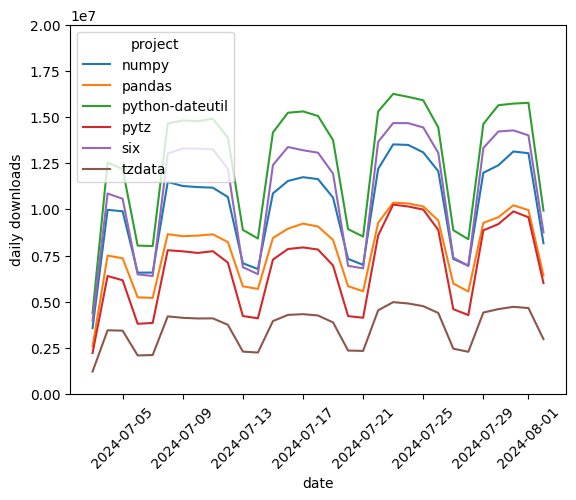

In [20]:
pd_timeseries = pd_df.unstack()
pd_timeseries.plot.line(rot=45, ylabel="daily downloads", ylim=(0, 2e7))